# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNetEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
dst_time = config.getint("data_preprocessing", "dst_time")
dst_length = dst_freq * dst_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
BATCH_SIZE = 64
dm = Cinc2017DataModule(batch_size=BATCH_SIZE)

## Create the Model


In [4]:
model = DenseNetEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr_scheduler_mode="multi_step",
    lr=1e-3,
    # min_lr = 1e-4,
    show_valid_cm=True,
    growth_rate=32,
    block_config=(6, 4, 4, 12, 8, 8, 24),
    num_init_features=64,
    bn_size=2,
    db_drop_rate=0.2,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (64  +  6 * 32) // 2 = 128
# (128 +  4 * 32) // 2 = 128
# (128 +  4 * 32) // 2 = 128
# (128 + 12 * 32) // 2 = 256
# (256 +  8 * 32) // 2 = 256
# (256 +  8 * 32) // 2 = 256
# (256 + 24 * 32) // 2 = 512

## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auprc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-densenet-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 1, dst_length))

Layer (type:depth-idx)                        Output Shape              Param #
DenseNetEcgModule                             [64, 3]                   --
├─DenseNetEcg: 1-1                            [64, 3]                   --
│    └─Sequential: 2-1                        [64, 512, 11]             --
│    │    └─Conv1d: 3-1                       [64, 64, 2900]            448
│    │    └─BatchNorm1d: 3-2                  [64, 64, 2900]            128
│    │    └─ReLU: 3-3                         [64, 64, 2900]            --
│    │    └─MaxPool1d: 3-4                    [64, 64, 1450]            --
│    │    └─_DenseBlock: 3-5                  [64, 256, 1450]           94,656
│    │    └─_Transition: 3-6                  [64, 128, 725]            33,280
│    │    └─_DenseBlock: 3-7                  [64, 256, 725]            71,552
│    │    └─_Transition: 3-8                  [64, 128, 362]            33,280
│    │    └─_DenseBlock: 3-9                  [64, 256, 362]            71,55

## Train the Model


In [7]:
trainer.fit(model, datamodule=dm)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: devilhyt to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNetEcg               | 3.2 M  | train | [1, 1, 5800] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 91/91 [00:09<00:00,  9.62it/s, v_num=i34e, lr=0.001, valid_loss=0.895, valid_acc=0.606, valid_auprc=0.431, valid_auroc=0.643, valid_f1=0.402, train_loss=1.080, train_acc=0.412, train_auprc=0.418, train_auroc=0.593, train_f1=0.406]

Epoch 0, global step 91: 'valid_auprc' reached 0.43080 (best 0.43080), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=0-step=91.ckpt' as top 1



Valid Confusion Matrix:
tensor([[681,  13,  68],
        [ 73,  25,  16],
        [285,  33,  44]], device='cuda:0')
Epoch 1: 100%|██████████| 91/91 [00:09<00:00,  9.91it/s, v_num=i34e, lr=0.001, valid_loss=0.724, valid_acc=0.703, valid_auprc=0.627, valid_auroc=0.815, valid_f1=0.552, train_loss=0.979, train_acc=0.504, train_auprc=0.522, train_auroc=0.695, train_f1=0.499]

Epoch 1, global step 182: 'valid_auprc' reached 0.62667 (best 0.62667), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=1-step=182.ckpt' as top 1



Valid Confusion Matrix:
tensor([[717,  29,  16],
        [ 26,  75,  13],
        [188,  96,  78]], device='cuda:0')
Epoch 2: 100%|██████████| 91/91 [00:09<00:00,  9.94it/s, v_num=i34e, lr=0.001, valid_loss=0.675, valid_acc=0.734, valid_auprc=0.759, valid_auroc=0.871, valid_f1=0.644, train_loss=0.795, train_acc=0.629, train_auprc=0.676, train_auroc=0.810, train_f1=0.622]

Epoch 2, global step 273: 'valid_auprc' reached 0.75878 (best 0.75878), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=2-step=273.ckpt' as top 1



Valid Confusion Matrix:
tensor([[677,  37,  48],
        [ 13,  94,   7],
        [150,  74, 138]], device='cuda:0')
Epoch 3: 100%|██████████| 91/91 [00:09<00:00,  9.93it/s, v_num=i34e, lr=0.001, valid_loss=0.688, valid_acc=0.733, valid_auprc=0.744, valid_auroc=0.862, valid_f1=0.620, train_loss=0.651, train_acc=0.721, train_auprc=0.777, train_auroc=0.876, train_f1=0.718]

Epoch 3, global step 364: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[719,  16,  27],
        [ 11, 102,   1],
        [187,  88,  87]], device='cuda:0')
Epoch 4: 100%|██████████| 91/91 [00:09<00:00,  9.84it/s, v_num=i34e, lr=0.001, valid_loss=0.736, valid_acc=0.733, valid_auprc=0.771, valid_auroc=0.861, valid_f1=0.633, train_loss=0.620, train_acc=0.738, train_auprc=0.798, train_auroc=0.887, train_f1=0.733]

Epoch 4, global step 455: 'valid_auprc' reached 0.77103 (best 0.77103), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=4-step=455.ckpt' as top 1



Valid Confusion Matrix:
tensor([[678,  47,  37],
        [  5, 107,   2],
        [134, 106, 122]], device='cuda:0')
Epoch 5: 100%|██████████| 91/91 [00:09<00:00,  9.89it/s, v_num=i34e, lr=0.001, valid_loss=0.477, valid_acc=0.815, valid_auprc=0.854, valid_auroc=0.923, valid_f1=0.766, train_loss=0.559, train_acc=0.766, train_auprc=0.835, train_auroc=0.908, train_f1=0.765]

Epoch 5, global step 546: 'valid_auprc' reached 0.85427 (best 0.85427), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=5-step=546.ckpt' as top 1



Valid Confusion Matrix:
tensor([[678,  23,  61],
        [  3, 101,  10],
        [ 89,  43, 230]], device='cuda:0')
Epoch 6: 100%|██████████| 91/91 [00:09<00:00,  9.84it/s, v_num=i34e, lr=0.001, valid_loss=0.517, valid_acc=0.809, valid_auprc=0.818, valid_auroc=0.895, valid_f1=0.759, train_loss=0.536, train_acc=0.778, train_auprc=0.847, train_auroc=0.915, train_f1=0.776]

Epoch 6, global step 637: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[726,   5,  31],
        [  6,  84,  24],
        [155,  16, 191]], device='cuda:0')
Epoch 7: 100%|██████████| 91/91 [00:09<00:00,  9.88it/s, v_num=i34e, lr=0.001, valid_loss=0.508, valid_acc=0.813, valid_auprc=0.844, valid_auroc=0.910, valid_f1=0.761, train_loss=0.524, train_acc=0.786, train_auprc=0.845, train_auroc=0.917, train_f1=0.782]

Epoch 7, global step 728: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[701,  15,  46],
        [  5, 105,   4],
        [111,  50, 201]], device='cuda:0')
Epoch 8: 100%|██████████| 91/91 [00:09<00:00,  9.89it/s, v_num=i34e, lr=0.001, valid_loss=0.587, valid_acc=0.760, valid_auprc=0.798, valid_auroc=0.890, valid_f1=0.683, train_loss=0.461, train_acc=0.816, train_auprc=0.879, train_auroc=0.936, train_f1=0.814]

Epoch 8, global step 819: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[669,  23,  70],
        [  7, 103,   4],
        [102,  91, 169]], device='cuda:0')
Epoch 9: 100%|██████████| 91/91 [00:09<00:00,  9.86it/s, v_num=i34e, lr=0.001, valid_loss=0.445, valid_acc=0.833, valid_auprc=0.858, valid_auroc=0.928, valid_f1=0.789, train_loss=0.461, train_acc=0.819, train_auprc=0.879, train_auroc=0.936, train_f1=0.816]

Epoch 9, global step 910: 'valid_auprc' reached 0.85848 (best 0.85848), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=9-step=910.ckpt' as top 1



Valid Confusion Matrix:
tensor([[728,   9,  25],
        [  5,  97,  12],
        [131,  25, 206]], device='cuda:0')
Epoch 10: 100%|██████████| 91/91 [00:09<00:00,  9.87it/s, v_num=i34e, lr=0.001, valid_loss=0.447, valid_acc=0.828, valid_auprc=0.861, valid_auroc=0.930, valid_f1=0.777, train_loss=0.444, train_acc=0.819, train_auprc=0.888, train_auroc=0.940, train_f1=0.817]

Epoch 10, global step 1001: 'valid_auprc' reached 0.86060 (best 0.86060), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=10-step=1001.ckpt' as top 1



Valid Confusion Matrix:
tensor([[722,   9,  31],
        [  2, 104,   8],
        [119,  44, 199]], device='cuda:0')
Epoch 11: 100%|██████████| 91/91 [00:09<00:00,  9.87it/s, v_num=i34e, lr=0.001, valid_loss=0.443, valid_acc=0.829, valid_auprc=0.858, valid_auroc=0.928, valid_f1=0.789, train_loss=0.429, train_acc=0.826, train_auprc=0.896, train_auroc=0.943, train_f1=0.825]

Epoch 11, global step 1092: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[685,  14,  63],
        [  3,  99,  12],
        [ 88,  32, 242]], device='cuda:0')
Epoch 12: 100%|██████████| 91/91 [00:09<00:00,  9.84it/s, v_num=i34e, lr=0.001, valid_loss=0.467, valid_acc=0.821, valid_auprc=0.822, valid_auroc=0.926, valid_f1=0.762, train_loss=0.399, train_acc=0.841, train_auprc=0.909, train_auroc=0.950, train_f1=0.839]

Epoch 12, global step 1183: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[723,   9,  30],
        [  5,  96,  13],
        [121,  43, 198]], device='cuda:0')
Epoch 13: 100%|██████████| 91/91 [00:09<00:00,  9.80it/s, v_num=i34e, lr=0.001, valid_loss=0.552, valid_acc=0.784, valid_auprc=0.842, valid_auroc=0.919, valid_f1=0.701, train_loss=0.388, train_acc=0.845, train_auprc=0.908, train_auroc=0.951, train_f1=0.843]

Epoch 13, global step 1274: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[703,  29,  30],
        [  2, 108,   4],
        [114,  88, 160]], device='cuda:0')
Epoch 14: 100%|██████████| 91/91 [00:09<00:00,  9.83it/s, v_num=i34e, lr=0.001, valid_loss=0.431, valid_acc=0.839, valid_auprc=0.877, valid_auroc=0.936, valid_f1=0.790, train_loss=0.406, train_acc=0.844, train_auprc=0.902, train_auroc=0.948, train_f1=0.844]

Epoch 14, global step 1365: 'valid_auprc' reached 0.87720 (best 0.87720), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=14-step=1365.ckpt' as top 1



Valid Confusion Matrix:
tensor([[714,   9,  39],
        [  4, 109,   1],
        [ 92,  54, 216]], device='cuda:0')
Epoch 15: 100%|██████████| 91/91 [00:09<00:00,  9.82it/s, v_num=i34e, lr=0.001, valid_loss=0.471, valid_acc=0.842, valid_auprc=0.870, valid_auroc=0.932, valid_f1=0.802, train_loss=0.371, train_acc=0.845, train_auprc=0.916, train_auroc=0.955, train_f1=0.844]

Epoch 15, global step 1456: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[703,  10,  49],
        [  2, 103,   9],
        [ 88,  37, 237]], device='cuda:0')
Epoch 16: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=i34e, lr=0.001, valid_loss=0.428, valid_acc=0.847, valid_auprc=0.875, valid_auroc=0.938, valid_f1=0.810, train_loss=0.365, train_acc=0.857, train_auprc=0.919, train_auroc=0.957, train_f1=0.855]

Epoch 16, global step 1547: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[684,  12,  66],
        [  2, 101,  11],
        [ 66,  33, 263]], device='cuda:0')
Epoch 17: 100%|██████████| 91/91 [00:09<00:00,  9.82it/s, v_num=i34e, lr=0.001, valid_loss=0.424, valid_acc=0.849, valid_auprc=0.868, valid_auroc=0.938, valid_f1=0.813, train_loss=0.357, train_acc=0.862, train_auprc=0.919, train_auroc=0.958, train_f1=0.861]

Epoch 17, global step 1638: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[686,   9,  67],
        [  4,  94,  16],
        [ 67,  24, 271]], device='cuda:0')
Epoch 18: 100%|██████████| 91/91 [00:09<00:00,  9.82it/s, v_num=i34e, lr=0.001, valid_loss=0.410, valid_acc=0.846, valid_auprc=0.890, valid_auroc=0.942, valid_f1=0.803, train_loss=0.356, train_acc=0.858, train_auprc=0.926, train_auroc=0.960, train_f1=0.858]

Epoch 18, global step 1729: 'valid_auprc' reached 0.88996 (best 0.88996), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=18-step=1729.ckpt' as top 1



Valid Confusion Matrix:
tensor([[714,   9,  39],
        [  3,  99,  12],
        [ 96,  32, 234]], device='cuda:0')
Epoch 19: 100%|██████████| 91/91 [00:09<00:00,  9.69it/s, v_num=i34e, lr=0.001, valid_loss=0.467, valid_acc=0.839, valid_auprc=0.869, valid_auroc=0.933, valid_f1=0.800, train_loss=0.374, train_acc=0.849, train_auprc=0.912, train_auroc=0.954, train_f1=0.846]

Epoch 19, global step 1820: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[703,  10,  49],
        [  2, 101,  11],
        [ 94,  33, 235]], device='cuda:0')
Epoch 20: 100%|██████████| 91/91 [00:09<00:00,  9.79it/s, v_num=i34e, lr=0.001, valid_loss=0.404, valid_acc=0.858, valid_auprc=0.891, valid_auroc=0.945, valid_f1=0.828, train_loss=0.336, train_acc=0.865, train_auprc=0.930, train_auroc=0.963, train_f1=0.864]

Epoch 20, global step 1911: 'valid_auprc' reached 0.89099 (best 0.89099), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=20-step=1911.ckpt' as top 1



Valid Confusion Matrix:
tensor([[702,   3,  57],
        [  4,  93,  17],
        [ 77,  18, 267]], device='cuda:0')
Epoch 21: 100%|██████████| 91/91 [00:09<00:00,  9.65it/s, v_num=i34e, lr=0.001, valid_loss=0.531, valid_acc=0.801, valid_auprc=0.859, valid_auroc=0.925, valid_f1=0.773, train_loss=0.338, train_acc=0.871, train_auprc=0.930, train_auroc=0.963, train_f1=0.870]

Epoch 21, global step 2002: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[627,  10, 125],
        [  3, 101,  10],
        [ 57,  41, 264]], device='cuda:0')
Epoch 22: 100%|██████████| 91/91 [00:09<00:00,  9.77it/s, v_num=i34e, lr=0.001, valid_loss=0.444, valid_acc=0.831, valid_auprc=0.876, valid_auroc=0.935, valid_f1=0.788, train_loss=0.324, train_acc=0.871, train_auprc=0.933, train_auroc=0.965, train_f1=0.870]

Epoch 22, global step 2093: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[711,   6,  45],
        [  4,  94,  16],
        [110,  28, 224]], device='cuda:0')
Epoch 23: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=i34e, lr=0.001, valid_loss=0.440, valid_acc=0.852, valid_auprc=0.873, valid_auroc=0.937, valid_f1=0.808, train_loss=0.338, train_acc=0.867, train_auprc=0.931, train_auroc=0.963, train_f1=0.867]

Epoch 23, global step 2184: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[725,   6,  31],
        [  6,  98,  10],
        [ 97,  33, 232]], device='cuda:0')
Epoch 24: 100%|██████████| 91/91 [00:09<00:00,  9.75it/s, v_num=i34e, lr=0.001, valid_loss=0.434, valid_acc=0.830, valid_auprc=0.879, valid_auroc=0.937, valid_f1=0.792, train_loss=0.326, train_acc=0.872, train_auprc=0.929, train_auroc=0.963, train_f1=0.870]

Epoch 24, global step 2275: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[710,   5,  47],
        [  8,  91,  15],
        [114,  21, 227]], device='cuda:0')
Epoch 25: 100%|██████████| 91/91 [00:09<00:00,  9.76it/s, v_num=i34e, lr=0.0001, valid_loss=0.398, valid_acc=0.851, valid_auprc=0.892, valid_auroc=0.945, valid_f1=0.817, train_loss=0.275, train_acc=0.894, train_auprc=0.950, train_auroc=0.974, train_f1=0.892]

Epoch 25, global step 2366: 'valid_auprc' reached 0.89208 (best 0.89208), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=25-step=2366.ckpt' as top 1



Valid Confusion Matrix:
tensor([[704,   6,  52],
        [  4,  97,  13],
        [ 86,  24, 252]], device='cuda:0')
Epoch 26: 100%|██████████| 91/91 [00:09<00:00,  9.69it/s, v_num=i34e, lr=0.0001, valid_loss=0.399, valid_acc=0.851, valid_auprc=0.895, valid_auroc=0.947, valid_f1=0.818, train_loss=0.265, train_acc=0.900, train_auprc=0.953, train_auroc=0.975, train_f1=0.901]

Epoch 26, global step 2457: 'valid_auprc' reached 0.89506 (best 0.89506), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=26-step=2457.ckpt' as top 1



Valid Confusion Matrix:
tensor([[702,   5,  55],
        [  4,  96,  14],
        [ 84,  23, 255]], device='cuda:0')
Epoch 27: 100%|██████████| 91/91 [00:09<00:00,  9.77it/s, v_num=i34e, lr=0.0001, valid_loss=0.396, valid_acc=0.855, valid_auprc=0.897, valid_auroc=0.947, valid_f1=0.823, train_loss=0.256, train_acc=0.902, train_auprc=0.954, train_auroc=0.977, train_f1=0.901]

Epoch 27, global step 2548: 'valid_auprc' reached 0.89686 (best 0.89686), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=27-step=2548.ckpt' as top 1



Valid Confusion Matrix:
tensor([[704,   4,  54],
        [  5,  96,  13],
        [ 81,  23, 258]], device='cuda:0')
Epoch 28: 100%|██████████| 91/91 [00:09<00:00,  9.78it/s, v_num=i34e, lr=0.0001, valid_loss=0.395, valid_acc=0.857, valid_auprc=0.896, valid_auroc=0.946, valid_f1=0.830, train_loss=0.233, train_acc=0.909, train_auprc=0.960, train_auroc=0.980, train_f1=0.908]

Epoch 28, global step 2639: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[694,   5,  63],
        [  3,  98,  13],
        [ 72,  21, 269]], device='cuda:0')
Epoch 29: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=i34e, lr=0.0001, valid_loss=0.404, valid_acc=0.847, valid_auprc=0.895, valid_auroc=0.946, valid_f1=0.818, train_loss=0.243, train_acc=0.908, train_auprc=0.960, train_auroc=0.980, train_f1=0.907]

Epoch 29, global step 2730: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[694,   7,  61],
        [  5,  98,  11],
        [ 82,  23, 257]], device='cuda:0')
Epoch 30: 100%|██████████| 91/91 [00:09<00:00,  9.77it/s, v_num=i34e, lr=0.0001, valid_loss=0.403, valid_acc=0.861, valid_auprc=0.896, valid_auroc=0.947, valid_f1=0.840, train_loss=0.241, train_acc=0.909, train_auprc=0.958, train_auroc=0.979, train_f1=0.909]

Epoch 30, global step 2821: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[699,   4,  59],
        [  5,  97,  12],
        [ 78,  14, 270]], device='cuda:0')
Epoch 31: 100%|██████████| 91/91 [00:09<00:00,  9.76it/s, v_num=i34e, lr=0.0001, valid_loss=0.401, valid_acc=0.860, valid_auprc=0.896, valid_auroc=0.947, valid_f1=0.835, train_loss=0.230, train_acc=0.913, train_auprc=0.964, train_auroc=0.981, train_f1=0.913]

Epoch 31, global step 2912: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   6,  58],
        [  4,  97,  13],
        [ 75,  17, 270]], device='cuda:0')
Epoch 32: 100%|██████████| 91/91 [00:09<00:00,  9.53it/s, v_num=i34e, lr=0.0001, valid_loss=0.403, valid_acc=0.855, valid_auprc=0.901, valid_auroc=0.948, valid_f1=0.835, train_loss=0.234, train_acc=0.913, train_auprc=0.963, train_auroc=0.981, train_f1=0.913]

Epoch 32, global step 3003: 'valid_auprc' reached 0.90055 (best 0.90055), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=32-step=3003.ckpt' as top 1



Valid Confusion Matrix:
tensor([[688,   3,  71],
        [  4,  96,  14],
        [ 74,  14, 274]], device='cuda:0')
Epoch 33: 100%|██████████| 91/91 [00:09<00:00,  9.76it/s, v_num=i34e, lr=0.0001, valid_loss=0.402, valid_acc=0.863, valid_auprc=0.898, valid_auroc=0.947, valid_f1=0.839, train_loss=0.223, train_acc=0.916, train_auprc=0.963, train_auroc=0.981, train_f1=0.916]

Epoch 33, global step 3094: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[699,   6,  57],
        [  4,  99,  11],
        [ 73,  18, 271]], device='cuda:0')
Epoch 34: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=i34e, lr=0.0001, valid_loss=0.395, valid_acc=0.871, valid_auprc=0.901, valid_auroc=0.948, valid_f1=0.846, train_loss=0.223, train_acc=0.915, train_auprc=0.964, train_auroc=0.981, train_f1=0.914]

Epoch 34, global step 3185: 'valid_auprc' reached 0.90083 (best 0.90083), saving model to 'wandb_logs/awin-densenet-ecg-centralized/pll8i34e/checkpoints/epoch=34-step=3185.ckpt' as top 1



Valid Confusion Matrix:
tensor([[707,   5,  50],
        [  4,  97,  13],
        [ 73,  15, 274]], device='cuda:0')
Epoch 35: 100%|██████████| 91/91 [00:09<00:00,  9.70it/s, v_num=i34e, lr=0.0001, valid_loss=0.405, valid_acc=0.864, valid_auprc=0.897, valid_auroc=0.947, valid_f1=0.839, train_loss=0.226, train_acc=0.914, train_auprc=0.965, train_auroc=0.981, train_f1=0.914]

Epoch 35, global step 3276: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[706,   4,  52],
        [  3,  97,  14],
        [ 78,  17, 267]], device='cuda:0')
Epoch 36: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=i34e, lr=0.0001, valid_loss=0.413, valid_acc=0.861, valid_auprc=0.898, valid_auroc=0.948, valid_f1=0.835, train_loss=0.211, train_acc=0.920, train_auprc=0.968, train_auroc=0.983, train_f1=0.920]

Epoch 36, global step 3367: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[695,   6,  61],
        [  2,  99,  13],
        [ 70,  20, 272]], device='cuda:0')
Epoch 37: 100%|██████████| 91/91 [00:09<00:00,  9.67it/s, v_num=i34e, lr=1e-5, valid_loss=0.411, valid_acc=0.865, valid_auprc=0.900, valid_auroc=0.948, valid_f1=0.841, train_loss=0.233, train_acc=0.912, train_auprc=0.963, train_auroc=0.981, train_f1=0.912]

Epoch 37, global step 3458: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[702,   5,  55],
        [  3,  95,  16],
        [ 75,  13, 274]], device='cuda:0')
Epoch 38: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=i34e, lr=1e-5, valid_loss=0.408, valid_acc=0.862, valid_auprc=0.899, valid_auroc=0.948, valid_f1=0.835, train_loss=0.207, train_acc=0.922, train_auprc=0.969, train_auroc=0.984, train_f1=0.921]

Epoch 38, global step 3549: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   6,  58],
        [  3,  98,  13],
        [ 72,  19, 271]], device='cuda:0')
Epoch 39: 100%|██████████| 91/91 [00:09<00:00,  9.69it/s, v_num=i34e, lr=1e-5, valid_loss=0.412, valid_acc=0.868, valid_auprc=0.899, valid_auroc=0.948, valid_f1=0.841, train_loss=0.217, train_acc=0.919, train_auprc=0.968, train_auroc=0.983, train_f1=0.920]

Epoch 39, global step 3640: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[706,   6,  50],
        [  3, 100,  11],
        [ 74,  20, 268]], device='cuda:0')
Epoch 40: 100%|██████████| 91/91 [00:09<00:00,  9.74it/s, v_num=i34e, lr=1e-5, valid_loss=0.418, valid_acc=0.864, valid_auprc=0.898, valid_auroc=0.948, valid_f1=0.838, train_loss=0.214, train_acc=0.914, train_auprc=0.968, train_auroc=0.983, train_f1=0.915]

Epoch 40, global step 3731: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[699,   6,  57],
        [  3,  98,  13],
        [ 70,  19, 273]], device='cuda:0')
Epoch 41: 100%|██████████| 91/91 [00:09<00:00,  9.71it/s, v_num=i34e, lr=1e-5, valid_loss=0.411, valid_acc=0.867, valid_auprc=0.899, valid_auroc=0.948, valid_f1=0.840, train_loss=0.211, train_acc=0.920, train_auprc=0.969, train_auroc=0.983, train_f1=0.921]

Epoch 41, global step 3822: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[703,   6,  53],
        [  3,  98,  13],
        [ 72,  18, 272]], device='cuda:0')
Epoch 42: 100%|██████████| 91/91 [00:09<00:00,  9.69it/s, v_num=i34e, lr=1e-5, valid_loss=0.412, valid_acc=0.859, valid_auprc=0.899, valid_auroc=0.948, valid_f1=0.835, train_loss=0.222, train_acc=0.918, train_auprc=0.964, train_auroc=0.982, train_f1=0.918]

Epoch 42, global step 3913: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[690,   6,  66],
        [  3,  97,  14],
        [ 68,  17, 277]], device='cuda:0')
Epoch 43: 100%|██████████| 91/91 [00:09<00:00,  9.54it/s, v_num=i34e, lr=1e-5, valid_loss=0.412, valid_acc=0.863, valid_auprc=0.900, valid_auroc=0.948, valid_f1=0.836, train_loss=0.211, train_acc=0.917, train_auprc=0.970, train_auroc=0.984, train_f1=0.918]

Epoch 43, global step 4004: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[703,   6,  53],
        [  3, 100,  11],
        [ 76,  21, 265]], device='cuda:0')
Epoch 44: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=i34e, lr=1e-5, valid_loss=0.420, valid_acc=0.866, valid_auprc=0.898, valid_auroc=0.948, valid_f1=0.838, train_loss=0.207, train_acc=0.917, train_auprc=0.969, train_auroc=0.984, train_f1=0.917]

Epoch 44, global step 4095: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[711,   5,  46],
        [  4,  96,  14],
        [ 81,  16, 265]], device='cuda:0')
Epoch 45: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=i34e, lr=1e-5, valid_loss=0.419, valid_acc=0.860, valid_auprc=0.898, valid_auroc=0.948, valid_f1=0.834, train_loss=0.208, train_acc=0.920, train_auprc=0.968, train_auroc=0.984, train_f1=0.920]

Epoch 45, global step 4186: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[698,   6,  58],
        [  3,  97,  14],
        [ 74,  18, 270]], device='cuda:0')
Epoch 46: 100%|██████████| 91/91 [00:09<00:00,  9.69it/s, v_num=i34e, lr=1e-5, valid_loss=0.414, valid_acc=0.867, valid_auprc=0.898, valid_auroc=0.948, valid_f1=0.842, train_loss=0.213, train_acc=0.920, train_auprc=0.969, train_auroc=0.984, train_f1=0.920]

Epoch 46, global step 4277: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[704,   6,  52],
        [  3,  98,  13],
        [ 75,  16, 271]], device='cuda:0')
Epoch 47: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=i34e, lr=1e-5, valid_loss=0.407, valid_acc=0.866, valid_auprc=0.901, valid_auroc=0.948, valid_f1=0.837, train_loss=0.221, train_acc=0.914, train_auprc=0.965, train_auroc=0.982, train_f1=0.913]

Epoch 47, global step 4368: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[706,   6,  50],
        [  3,  98,  13],
        [ 74,  20, 268]], device='cuda:0')
Epoch 48: 100%|██████████| 91/91 [00:09<00:00,  9.73it/s, v_num=i34e, lr=1e-5, valid_loss=0.416, valid_acc=0.862, valid_auprc=0.898, valid_auroc=0.948, valid_f1=0.835, train_loss=0.216, train_acc=0.920, train_auprc=0.964, train_auroc=0.982, train_f1=0.920]

Epoch 48, global step 4459: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[696,   6,  60],
        [  2,  98,  14],
        [ 69,  20, 273]], device='cuda:0')
Epoch 49: 100%|██████████| 91/91 [00:09<00:00,  9.72it/s, v_num=i34e, lr=1e-5, valid_loss=0.410, valid_acc=0.864, valid_auprc=0.900, valid_auroc=0.948, valid_f1=0.836, train_loss=0.209, train_acc=0.920, train_auprc=0.969, train_auroc=0.984, train_f1=0.920]

Epoch 49, global step 4550: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[705,   6,  51],
        [  3,  96,  15],
        [ 76,  17, 269]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate on the Test Set


In [8]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Last model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 38.75it/s]
test_loss: 0.4271091818809509
test_auprc: 0.8908934593200684
test_auroc: 0.9370443820953369
              precision    recall  f1-score   support

           N       0.90      0.92      0.91       762
           A       0.83      0.83      0.83       114
           O       0.79      0.74      0.77       362

    accuracy                           0.86      1238
   macro avg       0.84      0.83      0.83      1238
weighted avg       0.86      0.86      0.86      1238



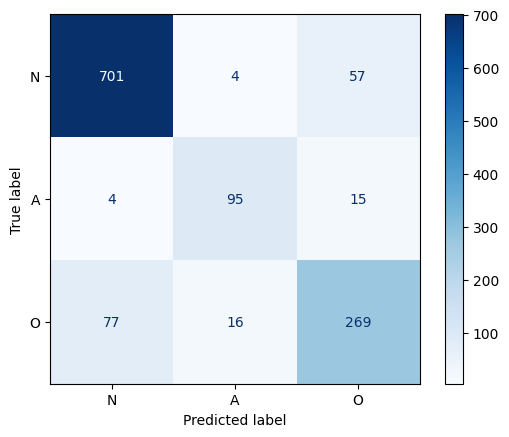

In [9]:
model = DenseNetEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auprc": test_auprc.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 39.30it/s]
test_loss: 0.42149585485458374
test_auprc: 0.8862521052360535
test_auroc: 0.9342010617256165
              precision    recall  f1-score   support

           N       0.89      0.93      0.91       762
           A       0.84      0.82      0.83       114
           O       0.79      0.73      0.76       362

    accuracy                           0.86      1238
   macro avg       0.84      0.83      0.83      1238
weighted avg       0.86      0.86      0.86      1238



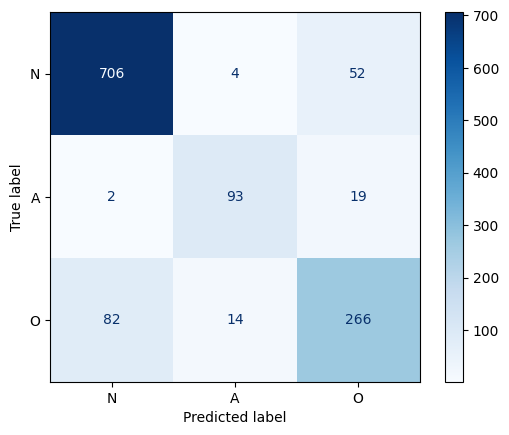

In [10]:
model = DenseNetEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auprc": test_auprc.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [11]:
wandb.finish()

best_test_accuracy,▁
best_test_auprc,▁
best_test_auroc,▁
best_test_f1,▁
best_test_loss,▁
epoch,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇███
last_test_accuracy,▁
last_test_auprc,▁
last_test_auroc,▁
last_test_f1,▁
last_test_loss,▁
